In [1]:
import torch
from models import GridMLMMelHarm
from GridMLM_tokenizers import CSGridMLMTokenizer
from data_utils import CSGridMLMDataset, CSGridMLM_collate_fn
from torch.utils.data import DataLoader
from train_utils import apply_structured_masking

/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batchsize = 1
val_dir = '/media/maindisk/maximos/data/hooktheory_all12_test'
tokenizer = CSGridMLMTokenizer(fixed_length=256)
val_dataset = CSGridMLMDataset(val_dir, tokenizer, 512)
valloader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False, collate_fn=CSGridMLM_collate_fn)

In [3]:
mask_token_id = tokenizer.mask_token_id
stage = 1
curriculum_type = 'ts_incr'
stage_aware = True

In [4]:
device_name = 'cuda:2'
if device_name == 'cpu':
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device(device_name)
    else:
        print('Selected device not available: ' + device_name)
model = GridMLMMelHarm(
    chord_vocab_size=len(tokenizer.vocab),
    conditioning_dim=16,
    device=device,
    max_stages=6
)
model_path = 'saved_models/' + curriculum_type +  '.pt'
checkpoint = torch.load(model_path, map_location=device_name, weights_only=True)
model.load_state_dict(checkpoint)
model.eval()
model.to(device)

GridMLMMelHarm(
  (condition_proj): Linear(in_features=16, out_features=512, bias=True)
  (melody_proj): Linear(in_features=100, out_features=512, bias=True)
  (harmony_embedding): Embedding(354, 512)
  (dropout): Dropout(p=0.3, inplace=False)
  (stage_embedding): Embedding(6, 64)
  (stage_proj): Linear(in_features=576, out_features=512, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (d

In [5]:
batch = next(iter(valloader))

/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


In [6]:
melody_grid = batch["pianoroll"].to(device)           # (B, 256, 140)
harmony_gt = batch["input_ids"].to(device)         # (B, 256)
conditioning_vec = batch["time_signature"].to(device)  # (B, C0)

In [7]:
# Apply masking to harmony
harmony_input, harmony_target = apply_structured_masking(
    harmony_gt,
    mask_token_id,
    stage,
    conditioning_vec,
    curriculum_type
)

In [8]:
logits = model(
    conditioning_vec.to(device),
    melody_grid.to(device),
    harmony_input.to(device),
    None if not stage_aware else stage
)

In [9]:
print(logits.shape)

torch.Size([1, 256, 354])


In [10]:
output_ids = torch.argmax(logits, dim=-1)

output_tokens = []
for i,t in enumerate(output_ids[0].tolist()):
    output_tokens.append( str(i) + ':' + tokenizer.ids_to_tokens[t] )
print('output_tokens')
print(output_tokens)

harmony_input_tokens = []
for i,t in enumerate(harmony_input[0].tolist()):
    harmony_input_tokens.append( str(i) + ':' + tokenizer.ids_to_tokens[t] )
print('harmony_input_tokens')
print(harmony_input_tokens)

harmony_target_tokens = []
for i,t in enumerate(harmony_target[0].tolist()):
    if t < 0:
        harmony_target_tokens.append( str(i) + ':' + '<mask>' )
    else:
        harmony_target_tokens.append( str(i) + ':' + tokenizer.ids_to_tokens[t] )
print('harmony_target_tokens')
print(harmony_target_tokens)

harmony_gt_tokens = []
for i,t in enumerate(harmony_gt[0].tolist()):
    harmony_gt_tokens.append( str(i) + ':' + tokenizer.ids_to_tokens[t] )
print('harmony_gt_tokens')
print(harmony_gt_tokens)

output_tokens
['0:A:maj', '1:F#:min', '2:A:maj', '3:A:maj', '4:E:maj', '5:A:maj', '6:E:maj', '7:E:maj', '8:A:maj', '9:E:maj', '10:E:maj', '11:A:maj', '12:A:maj', '13:E:maj', '14:F#:min', '15:A:maj', '16:F#:min', '17:A:maj', '18:A:maj', '19:F#:min', '20:F#:min', '21:E:maj', '22:E:maj', '23:E:maj', '24:F#:min', '25:A:maj', '26:F#:min', '27:A:maj', '28:A:maj', '29:A:maj', '30:A:maj', '31:A:maj', '32:A:maj', '33:A:maj', '34:A:maj', '35:F#:min', '36:A:maj', '37:E:maj', '38:E:maj', '39:E:maj', '40:A:maj', '41:A:maj', '42:F#:min', '43:E:maj', '44:A:maj', '45:E:maj', '46:E:maj', '47:E:maj', '48:A:maj', '49:A:maj', '50:A:maj', '51:A:maj', '52:A:maj', '53:A:maj', '54:A:maj', '55:F#:min', '56:E:maj', '57:A:maj', '58:A:maj', '59:E:maj', '60:E:maj', '61:E:maj', '62:A:maj', '63:A:maj', '64:A:maj', '65:E:maj', '66:A:maj', '67:E:maj', '68:E:maj', '69:A:maj', '70:E:maj', '71:E:maj', '72:A:maj', '73:E:maj', '74:A:maj', '75:F#:min', '76:A:maj', '77:F#:min', '78:E:maj', '79:E:maj', '80:F#:min', '81:A:maj'

In [11]:
import matplotlib.pyplot as plt

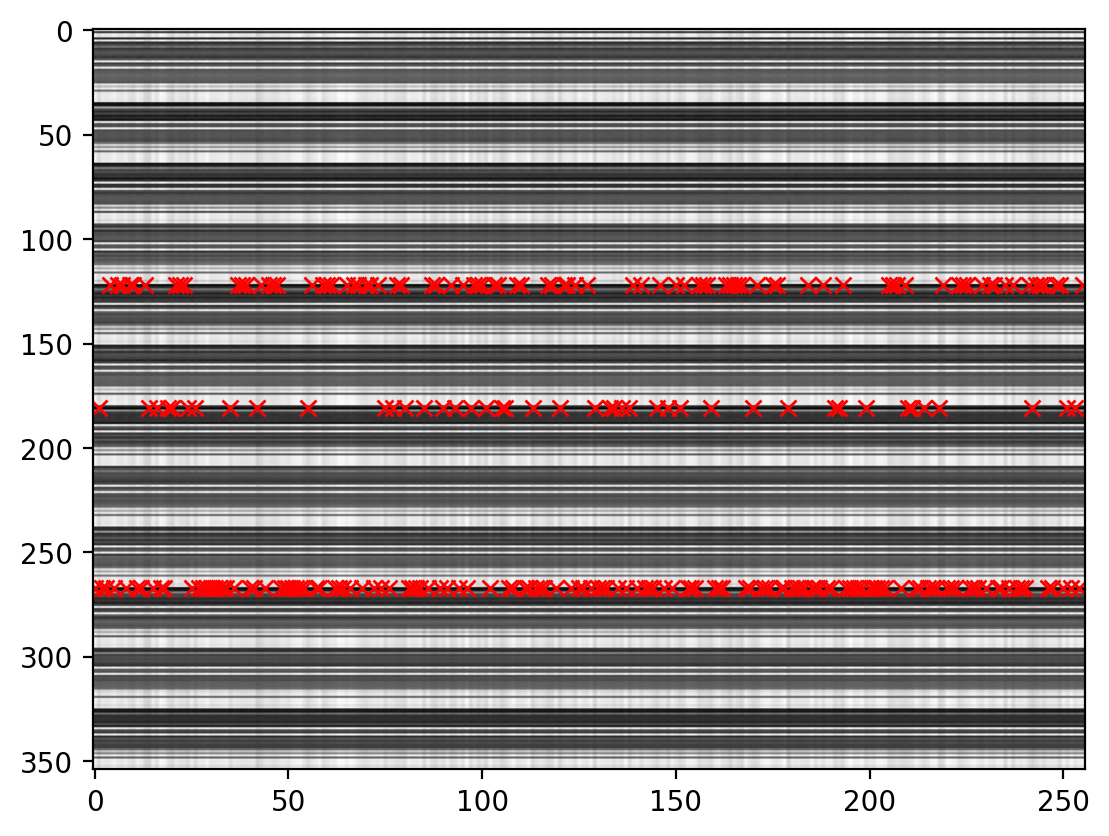

In [12]:
plt.imshow(logits[0,:,:].detach().cpu().numpy().T, aspect='auto', cmap='gray_r',)
plt.plot(output_ids.detach().cpu().numpy().T, 'rx')